In [45]:
from random import shuffle
from src.utils import *
import os
import sklearn.metrics
import tensorflow as tf

In [46]:
dataset_name = "nyt2"
data_dir = os.path.join("data", dataset_name)
encoder = "pcnn"
selector = "att"
l2_lambd = 0.0
batch_size = 64

preprocessed_data_dir = get_preprocessed_dir(data_dir)
if not os.path.exists(preprocessed_data_dir):
    os.mkdir(preprocessed_data_dir)

#preprocessor_batch(data_dir)

from src.model import Model
tf.reset_default_graph()
_, word_vec_mat = load_word_vec(os.path.join("data", dataset_name))
max_classes = 53
model = Model(word_vec_mat, encoder = encoder, selector=selector, no_of_classes=max_classes)
print("Setting max class size to : ", max_classes)
train_data = load_data(preprocessed_data_dir, max_classes)
dev_data = load_data(preprocessed_data_dir, max_classes, "test")


n_epochs = 4
pair_bag_loc = train_data[-1]
pairs = list(pair_bag_loc.keys())
dev_pair_bag_loc = dev_data[-1]
dev_pairs = list(dev_pair_bag_loc.keys())
dev_pairs_dict = get_dev_pairs_dict(dev_pairs)
n_dev_batches = len(dev_pairs) // batch_size


def na_nonNA(pairs):
    not_NA_rels = 0
    naPairs = []
    nonNaPairs = []
    for k in pairs:
        if k.split("#")[2] != "0":
            nonNaPairs.append(k)
        else:
            naPairs.append(k)
    return naPairs, nonNaPairs

trainNa, trainNonNa = na_nonNA(pairs)
devNa, devNonNa = na_nonNA(dev_pairs)
not_NA_rels = len(devNonNa)
print("Pairs in train dataset NA and non NA : ", len(trainNa), len(trainNonNa))
print("Pairs in train dataset NA and non NA : ", len(devNa), len(devNonNa))
"""
all_words, all_pos1, all_pos2, all_masks, all_lengths, \
all_inst_rels, pair_bag_loc = train_data
all_dev_words, all_dev_pos1, all_dev_pos2, all_dev_masks, \
all_dev_lengths, all_dev_inst_rels, dev_pair_bag_loc = dev_data
"""


Creating model with encoder and selector :  pcnn att
121 (?, 120, 230)
121 (?, 120, 230)
(?, 690)
Created model with no bootstrapping, bs val : 0.0
Setting max class size to :  53
Pairs in train dataset NA and non NA :  262336 18252
Pairs in train dataset NA and non NA :  94917 1950


'\nall_words, all_pos1, all_pos2, all_masks, all_lengths, all_inst_rels, pair_bag_loc = train_data\nall_dev_words, all_dev_pos1, all_dev_pos2, all_dev_masks, all_dev_lengths, all_dev_inst_rels, dev_pair_bag_loc = dev_data\n'

In [47]:
model.mloader(os.path.join("saved", "models", "pcnn_att_nyt2_none_53_n_0_0.3455"))

path : saved/models/pcnn_att_nyt2_none_53_n_0_0.3455
INFO:tensorflow:Restoring parameters from saved/models/pcnn_att_nyt2_none_53_n_0_0.3455


In [48]:
def test_dev(dev_pairs = dev_pairs):
    test_res = []
    for i in range(n_dev_batches):
      batch_keys = dev_pairs[i * batch_size : (i + 1) * batch_size]
      words, pos1, pos2, inst_rels, masks, lengths, \
        rels, scope = batch_maker(dev_data, batch_keys)
      pos1[pos1 > 239] = 239
      pos2[pos2 > 239] = 239
      pos1[pos1 < 0] = 0
      pos2[pos2 < 0] = 0
      output, atts = model.test_batch(words, pos1, pos2, inst_rels, 
        masks, lengths, rels, scope)
      for i, k in enumerate(batch_keys):
        entPair = "#".join(k.split("#")[:2])
        entPairRels = dev_pairs_dict[entPair]
        for j in range(1, 53):
          correct = 0
          if j in entPairRels:
            correct = 1
          if output[i][j] > 0.01:
            test_res.append({"entPair" : entPair, 
                "score" : output[i][j], 
                "correct" : correct, 
                "pred" : j, 
                "actual" : entPairRels,
                "atts" : atts[i][j]})
#       print(test_res)
    prec = []
    recall = []
    correct = 0
    sorted_test_result = sorted(test_res, key=lambda x: x['score'], reverse = True)
    
    import time
    start = time.time()

    for i, item in enumerate(sorted_test_result):
      if item["correct"]:
        correct += 1  
      prec.append(float(correct) / (i + 1))
      recall.append(float(correct) / not_NA_rels)
    return prec, recall, sorted_test_result[:5000]

In [49]:
p, r, sorted_test_result = test_dev()

In [50]:
use_top = 100

atts_max = []
atts_min = []
bag_lengths = []
atts_max_filter_3_instances = []
atts_max_2nd_filter_3_instances = []
atts_min_filter_3_instances = []
bag_lengths_filter_3_instances = []
for i in range(use_top):
    atts_max.append(max(sorted_test_result[i]['atts']))
    bag_lengths.append(len(sorted_test_result[i]['atts']))
    atts_min.append(min(sorted_test_result[i]['atts']))
    if len(sorted_test_result[i]['atts']) > 2:
        atts_max_filter_3_instances.append(max(sorted_test_result[i]['atts']))
        atts_max_2nd_filter_3_instances.append(sorted(sorted_test_result[i]['atts'], reverse = True)[1])
        atts_min_filter_3_instances.append(min(sorted_test_result[i]['atts']))
        bag_lengths_filter_3_instances.append(len(sorted_test_result[i]['atts']))

In [51]:
import seaborn as sns

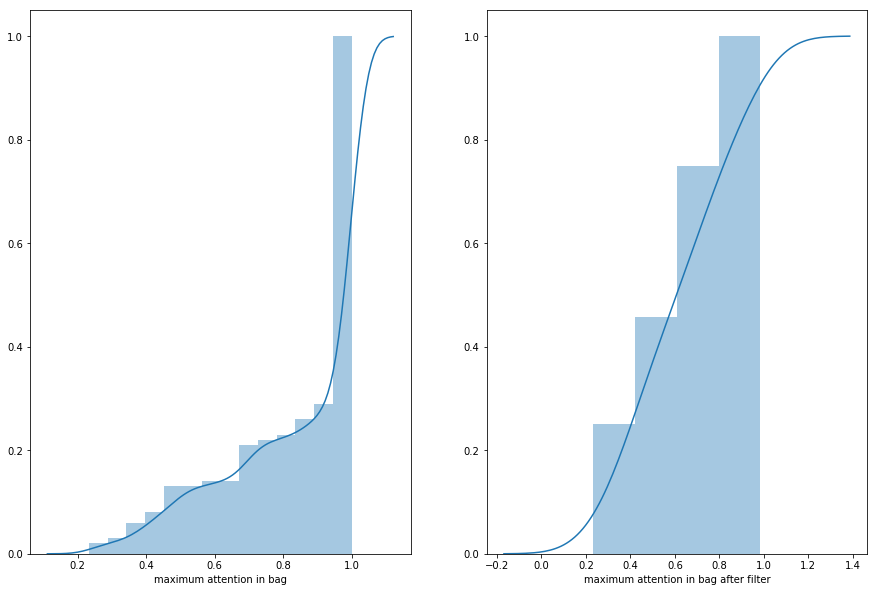

In [57]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(1,2,figsize=(15,10))
ax_iter = iter(axs.flat)
plots = [atts_max, atts_min,
         bag_lengths, bag_lengths_filter_3_instances,
         atts_max, atts_max_filter_3_instances,
         atts_max_filter_3_instances, atts_min_filter_3_instances,
         atts_max_filter_3_instances, atts_max_2nd_filter_3_instances]
ax = next(ax_iter)
sns.distplot(atts_max, ax=ax, hist_kws=dict(cumulative=True), kde_kws=dict(cumulative=True), axlabel="maximum attention in bag")
ax = next(ax_iter)
sns.distplot(atts_max_filter_3_instances, ax=ax, hist_kws=dict(cumulative=True), kde_kws=dict(cumulative=True), axlabel="maximum attention in bag after filter")
plt.savefig("Attention_weights_dist.png")

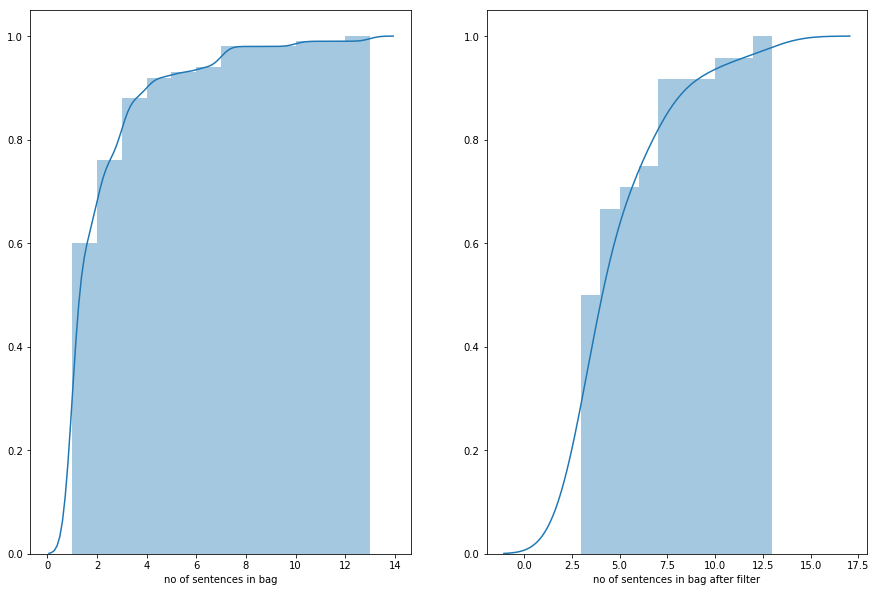

In [60]:
fig, axs = plt.subplots(1,2,figsize=(15,10))
ax_iter = iter(axs.flat)
ax = next(ax_iter)
sns.distplot(bag_lengths, bins = [i for i in range(14)], ax=ax, hist_kws=dict(cumulative=True), kde_kws=dict(cumulative=True), axlabel="no of sentences in bag")
ax = next(ax_iter)
sns.distplot(bag_lengths_filter_3_instances, bins = [i for i in range(3, 14)], ax=ax, hist_kws=dict(cumulative=True), kde_kws=dict(cumulative=True), axlabel="no of sentences in bag after filter")
plt.savefig("Bag_lengths_dist.png")

In [53]:
from collections import Counter
print(bag_lengths)
print(Counter(bag_lengths))

[7, 1, 1, 1, 1, 1, 1, 1, 1, 1, 13, 1, 1, 1, 4, 2, 1, 1, 3, 2, 5, 1, 2, 2, 1, 2, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 2, 1, 1, 2, 1, 3, 2, 1, 1, 1, 3, 1, 3, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 4, 3, 7, 7, 1, 2, 1, 1, 3, 4, 1, 1, 2, 6, 1, 1, 2, 3, 3, 3, 4, 2, 1, 2, 1, 7, 2, 1, 1, 3, 3, 1, 1, 1, 1, 1, 1, 2, 1, 10, 1]
Counter({1: 60, 2: 16, 3: 12, 7: 4, 4: 4, 13: 1, 5: 1, 6: 1, 10: 1})


AxesSubplot(0.125,0.125;0.775x0.755)


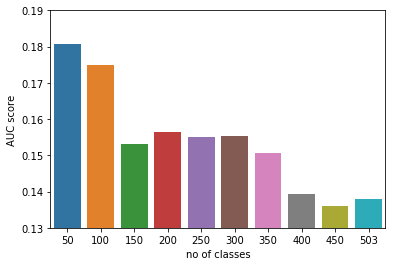

In [54]:
import matplotlib.pyplot as plt
plt.ylim(0.13, 0.19)
temp = [(50 , 0.1806), (100, 0.1748), (150, 0.1531), (200, 0.1564), (250, 0.1550), (300, 0.1554), (350, 0.1506), (400, 0.1392), (450, 0.1360), (503, 0.1379)]
x = [t[0] for t in temp]
y = [t[1] for t in temp]
fig = sns.barplot(x, y)
fig.set(xlabel="no of classes", ylabel="AUC score")
print(fig)
fig = fig.figure
fig.savefig("temp")